# Reinforcement Learning - Game of Snake - by the Irchel Crew
### with Atchuthan Sriranjan, Vincent Müller and Yves Boutellier 
#### submitted on the 15th of December 2020  at the University of Zurich 
#### Reinforcement Learning Seminar

## Table of contents

#### 0. Intro
    0.0 Theoretical Intro to Reinforcement Learning
    0.1 Project Description
    0.2 Technical Details of our Machine used for Training
    0.3 States, Rewards and Features
    0.4 Our Code Implementation of Snake
#### 1. Double DQN
    1.1 Theory
    1.2 Our final Code
    1.3 Attempts
    1.4 Video of the agent's performance
#### 2. Double DQN with CNN
    2.1 Theory
    2.2 Our final Code
    2.3 Attempts
    2.4 Video of the agent's performance
#### 3. Policy Gradient
    3.1 Theory
    3.2 Our final Code
    3.3 Attempts
    3.4 Video of the agent's performance
#### 4. Results and Discussion
#### 5. Conclusion
#### 6. References

## 0. Intro
### 0.0 Theoretical Intro to Reinforcement Learning
When an agent is dropped into a new, unseen environment it has no idea of the dynamics, possible actions, dangers or rewards. While we, as RL practitioners, can give the agent the possible actions, the agent has to lern itself, how to get the reward and avoid danger that are part of the dynamics. The goal we set for the agent is to learn sequences of actions that give him the most possible reward. We use the reward to reinforce certain actions as well as we use punishment (ie. negative reward) to prevent the agent taking undesired action.


### 0.1 Project Description

The goal of this project was to create Reinforcent Learning agents that can play the game of snake at a decent level. Games are particular interesting since they offer an environment that is easy to simulate. However the environment can be enough complex and actions that the agent is going to take will often only turn out later into reward.

We try different approaches, that use Q-Learning or Policy-Gradients. 
We detail our implementation, testing, feature engineering, and hyperparameter search, and eventually these results will be discussed and analyzed in section 5.

### 0.2 Technical Details of our machine used for training of the Deep Neural Networks and CNN

### 0.3 Information about the environment - States, Rewards and Actions 

#### States
The possible states depend on the model the agent is using. 
Our models without a CNN need information about the environment encoded in a matrix. We tried the one hot encoding like listed below.

* apple above snake (0 or 1)
* apple below snake (0 or 1)
* apple right of snake (0 or 1)
* apple left of snake (0 or 1)
* obstacle one grid element above snake (Wall or snake body) (0 or 1)
* obstacle one grid element below snake (0 or 1)
* obstacle one grid element right of snake (0 or 1)
* obstacle one grid element left of snake (0 or 1)
* snake movement up (0 or 1)
* snake movement down (0 or 1)
* snake movement left (0 or 1)
* snake movement right (0 or 1)

We also tried other strategies than one-hot encoding, ie. we had for snake movement, obstacles and apple integers 0-3 encoding the 4 possible states for each. But this was inferior to the one-hot encoding. We assume, that the signal was not clear enough for the neural network to distinguish. 0 or 1 in one place is probably easier to recognise, than the subtle difference between 0,1,2 and 3.

Our models with a CNN receive visual input. The visual input means frames of the playboard. We stacked frames so that the agent receives a visual input with temporal information. We will test different number of stacked frames giving the CNN more or less "memory".

#### Rewards
The exact rewards depend on the different models we choose. But they have in common, that eating an apple gives a positive reward and dying gives a negative reward. Additionally models can have rewards for other events like approaching the apple or a negative reward for each time step.

In the section 5. we will discuss the different approaches.

#### Actions
The models are indistinguishable regarding the possible actions. In the game of snake only for actions are possible. Moving up, down, left or right.

### 0.4 Our Code Implementation of Snake

In [ ]:
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import time
import tensorflow as tf

####### Reinforcement learning ##########
from DeepQLearning import DQNAgent
#from PolicyGradients import PolicyGradientAgent
from DeepQLearningEager import DQAgent
from DeepQCNN import DQCNNAgent
import os
import imageio
import matplotlib.animation as animation
from scipy.ndimage import zoom
#from celluloid import Camera
#import atchuPolicyGradients



##zero = empty, 1 = snake, 2 = apple
##


"global parameters"
up = 0
down = 1
left = 2
right = 3
up_vect = np.array([-1, 0])
down_vect = np.array([1, 0])
left_vect = np.array([0, -1])
right_vect = np.array([0, 1])

direction_to_string = {0: "up", 1: "down", 2: "left", 3: "right"}
direction_to_one_hot = {0: [1, 0, 0, 0], 1: [0, 1, 0, 0], 2: [0, 0, 1, 0], 3: [0, 0, 0, 1]}

sleep = 0.025

def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray



class Naive_agent(object):
    def __init__(self, board_len):
        self.board_len = board_len
        self.counter = 0

    def dodge_1(self, new):
        return np.flip(new)

    def dodge_2(self, new):
        return -np.flip(new)

    def dodge_3(self, new):
        return -new

    def is_dying(self, snake_body, new):
        # this checks, if the snake will die, if it continues to move i the direction of the apple.
        # first, it checks if there is a snake body part or a wall and it checks also if
        # it will move into a dead end.
        return np.any(np.all(snake_body[-1] + new == np.array(snake_body[:-1]), axis=1)) or \
               np.any(0 > (snake_body[-1] + new)) or np.any((snake_body[-1] + new) >= self.board_len) \
               or \
               (np.any(np.all(snake_body[-1] + new + np.flip(new) == np.array(snake_body[:-1]), axis=1)) \
                or np.any(0 > (snake_body[-1] + new + np.flip(new))) or np.any(
                           (snake_body[-1] + new + np.flip(new)) >= self.board_len)) \
               and \
               (np.any(np.all(snake_body[-1] + new - np.flip(new) == np.array(snake_body[:-1]), axis=1))
                or np.any(0 > (snake_body[-1] + new - np.flip(new))) or np.any(
                           (snake_body[-1] + new - np.flip(new)) >= self.board_len)) \
               and \
               (np.any(np.all(snake_body[-1] + 2 * new == np.array(snake_body[:-1]), axis=1))
                or np.any(0 > (snake_body[-1] + new - np.flip(new))) or np.any(
                           (snake_body[-1] + new - np.flip(new)) >= self.board_len))

    def get_action(self, snake_body, apple_coords):
        self.counter += 1
        vect = snake_body[-1] - apple_coords
        max_abs = np.argmax(np.abs(vect))
        new = np.zeros(2, dtype=int)
        new[max_abs] = -np.sign(vect[max_abs])

        new_copy = new.copy()
        if len(snake_body) >= 2:
            if self.counter % 2 == 0:
                # print("dying:",np.any(np.all(snake_body[-1]+new == np.array(snake_body[:-1]),axis =1)))
                if (self.is_dying(snake_body, new)):
                    new = self.dodge_1(new_copy)
                if (self.is_dying(snake_body, new)):
                    new = self.dodge_2(new_copy)
                if (self.is_dying(snake_body, new)):
                    new = self.dodge_3(new_copy)
            else:
                if (self.is_dying(snake_body, new)):
                    new = self.dodge_2(new_copy)
                if (self.is_dying(snake_body, new)):
                    new = self.dodge_1(new_copy)
                if (self.is_dying(snake_body, new)):
                    new = self.dodge_3(new_copy)
        return new


class Snake(object):
    def __init__(self, board_len):
        self.apple_eaten_this_round = False
        self.alive = True
        self.board_len = board_len
        self.direction = down
        self.direction_vect = None
        self.direction_to_vect = {up: up_vect, down: down_vect, left: left_vect, right: right_vect}
        self.len = 1
        self.body = [np.random.randint(0, board_len, 2)]
        self.ate_apple_this_round = False
    def move(self, direction):
        move = self.direction_to_vect[direction]
        self.body.append(self.body[-1] + move)
        if len(self.body) > self.len:
            self.body.pop(0)
        self.direction = direction
        self.direction_vect = move
    def eat_apple(self):
        self.len += 1
    def get_body(self):
        return self.body
    def is_alive(self):
        self.alive = True
        if len(self.body) > 1:
            if np.any(np.all(self.body[-1] == np.array(self.body[:-1]), axis=1)):
                self.alive = False
        if np.any((np.array(self.body) < 0) | (np.array(self.body) >= self.board_len), axis=None):
            self.alive = False
        return self.alive


class Statespace_manager(object):
    # self.board
    # self.apple_coords
    # self.snake
    def apple_direction(self):
        vect = self.snake.body[-1] - self.apple_coords
        max_abs = np.argmax(np.abs(vect))
        new = np.zeros(2, dtype=int)
        new[max_abs] = -np.sign(vect[max_abs])
        direction_int = self.direction_encoder[tuple(new)]
        return direction_int
    def apple_direction_one_hot(self):
        return direction_to_one_hot[self.apple_direction()]
    def snake_direction(self):
        return self.snake.direction
    def snake_direction_one_hot(self):
        return direction_to_one_hot[self.snake.direction]
    def obstacle_up(self):
        up = (np.any(np.all(self.snake.body[-1] + up_vect == np.array(self.snake.body[:]), axis=1)) \
              or np.any(0 > (self.snake.body[-1] + up_vect)) or np.any(
                    (self.snake.body[-1] + up_vect >= self.board_len)))
        return int(up)
    def obstacle_down(self):
        down = (np.any(np.all(self.snake.body[-1] + down_vect == np.array(self.snake.body[:]), axis=1)) \
                or np.any(0 > (self.snake.body[-1] + down_vect)) or np.any(
                    (self.snake.body[-1] + down_vect >= self.board_len)))
        return int(down)
    def obstacle_left(self):
        left = (np.any(np.all(self.snake.body[-1] + left_vect == np.array(self.snake.body[:]), axis=1)) \
                or np.any(0 > (self.snake.body[-1] + left_vect)) or np.any(
                    (self.snake.body[-1] + left_vect >= self.board_len)))
        return int(left)
    def obstacle_right(self):
        right = (np.any(np.all(self.snake.body[-1] + right_vect == np.array(self.snake.body[:]), axis=1)) \
                 or np.any(0 > (self.snake.body[-1] + right_vect)) or np.any(
                    (self.snake.body[-1] + right_vect >= self.board_len)))
        return int(right)
    def get_state(self):
        if self.pixels == True:
            for i in range(self.n_stacked_frames-1):
                self.stacked_frames[:,:,i] = self.stacked_frames[:,:,i+1]
                self.stacked_frames[:,:,0] = rgb2gray(self.board)
                return np.array(self.stacked_frames)
        else:
            state = np.array(
                [*self.apple_direction_one_hot(), *self.snake_direction_one_hot(), self.obstacle_up(), self.obstacle_down(),
                self.obstacle_left(), self.obstacle_right()])
        return state
    def set_state_space_len(self):
        self.state_space_len = len(self.get_state())
    def get_state_space_len(self):
        return self.state_space_len


class Actionspace_manager(object):
    def action(self):
        return self.snake.direction

    def get_action_space_len(self):
        return self.action_space_len


class Reward_manager(object):
    def efficiency_reward(self):
        return self.apple_bonus

    def apple_reward(self):
        if self.snake.apple_eaten_this_round:
            # print("apple reward:",10)
            return 100
        else:
            return 0

    def death_reward(self):
        if not self.snake.is_alive():
            # print("death reward:", -10)
            return -100
        else:

            return 0

    def direction_reward(self):
        vect = self.apple_coords - self.snake.body[-1]
        target_dir = np.argmax(np.abs(vect))
        new_vect = np.zeros(2, dtype=int)
        new_vect[target_dir] = -np.sign(vect[target_dir])
        if np.sum(np.abs((self.snake.body[-1] - self.snake.direction_vect) - self.apple_coords)) \
                > np.sum(np.abs(self.snake.body[-1] - self.apple_coords)) or self.snake.apple_eaten_this_round:
            # print("direction_reward: ",1)
            return 1
        else:
            # print("direction_reward: ",-1)
            return -1

    def step_reward(self):
        return -0.1

    def get_reward(self):
        return self.apple_reward() + self.death_reward() + self.direction_reward()

class VideoRecorder(object):
        def __init__(self):
            self.video_frames = []
            self.scores = []
        def store(self, arr,score):
            self.video_frames.append(arr)
            self.scores.append(score)
        def save_video(self, dir_name, game_counter, highscore):
            fig, ax = plt.subplots(1, 1)
            img = ax.imshow(self.video_frames[0], animated = True)
            n_frames = len(self.video_frames)
            props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
            text = ax.text(0.05, 1.1, f"score: {self.scores[0]}, games:{game_counter}, highscore:{highscore}" \
                         , transform=ax.transAxes, fontsize=14, \
                         verticalalignment='top', bbox=props)
            def update(counter):
                text.set_text( f"score: {self.scores[counter]}, games:{game_counter}, highscore:{highscore}" )
                img.set_array(self.video_frames[counter])
                return [img]
            ani = animation.FuncAnimation(fig, update, frames=n_frames, blit=False, interval=500)
            ani.save(f"Gifs/{dir_name}/episode_{game_counter}.mp4")
            plt.close(fig)
        def reset(self):
            self.video_frames = []
            self.scores = []

class Board(Statespace_manager, Reward_manager, Actionspace_manager,):
    def reset_board(self):

        self.snake = Snake(self.board_len)
        self.apple_coords = np.random.randint(0, self.board_len, 2)
        self.score = 0

    def __init__(self, board_len,dir_name,pixels=True,n_stacked_frames = 1, skip=1000):
        if not os.path.exists(os.path.join("Gifs",dir_name)):
            os.makedirs(os.path.join("Gifs", dir_name))
        if not os.path.exists("Scores"):
            os.makedirs("Scores")
        if not os.path.exists("Models"):
            os.makedirs("Models")
        if not os.path.exists("Introspection"):
            os.makedirs("Introspection")
        self.scores  = []
        self.dir_name = dir_name
        self.video_frames = []
        self.n_stacked_frames = n_stacked_frames
        self.stacked_frames = np.zeros(shape=(board_len, board_len, n_stacked_frames))
        self.pixels = pixels
        self.highscore = 0
        self.statespace_manager = Statespace_manager()
        self.reward_manager = Reward_manager()
        self.apple_bonus = board_len
        self.game_counter = 0
        self.action_space = np.array([up, down, left, right])
        self.action_space_len = len(self.action_space)
        self.state_space_len = 0
        ####### for skipping transitions
        self.skip = skip
        self.step_counter = 0
        ###########################
        self.direction_encoder = {tuple(up_vect): up, tuple(down_vect): down, tuple(left_vect): left,
                                  tuple(right_vect): right}
        # plt.ion()
        self.score = 0
        self.fig = plt.gcf()
        self.ax = plt.gca()

        #self.camera = Camera(self.fig)
        # self.fig.canvas.mpl_connect('close_event', self.closeHandler)
        self.props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        self.ax.text(0.05, 0.95, "score:", transform=self.ax.transAxes, fontsize=14, \
                     verticalalignment='top', bbox=self.props)
        self.board_len = board_len
        self.board = np.zeros((board_len, board_len, 3))
        self.snake = Snake(board_len)
        self.apple_coords = np.random.randint(0, board_len, 2)
        self.ate_apple_this_round = False
        ###################ugly
        self.set_state_space_len()
        ###################
        self.img = self.ax.imshow(self.board)

    def get_board_len(self):
        return self.board_len

    def get_apple_coords(self):
        return self.apple_coords

    def get_snake(self):
        return self.snake

    def set_apple(self):
        while np.any(np.all(self.apple_coords == np.array(self.snake.get_body()), axis=1)):
            self.apple_coords = np.random.randint(0, self.board_len, 2)

    def print_board(self):
        if self.step_counter == self.skip:
            plt.ion()
        if self.step_counter >= self.skip:
            self.ax.clear()
            self.ax.text(0.05, 1.1, f"score: {self.score}, games: {self.game_counter}, highscore: {self.highscore}" \
                         , transform=self.ax.transAxes, fontsize=14, \
                         verticalalignment='top', bbox=self.props)
            self.ax.imshow(self.board, interpolation='none' ,animated = False)
            plt.pause(0.025)

    def update_board(self):
        self.board[:, :, :] = np.array([1., 1., 1.])  # resetting board
        self.board[self.apple_coords[0], self.apple_coords[1]] = np.array([1., 0, 0])  # printing apple
        for i in range(len(self.snake.body[:-1])):
            loc = self.snake.body[i]
            self.board[loc[0], loc[1], :] = np.array([0., 1., 0.])
            # i/(2*len(self.snake.get_body()))
        # print(self.board)
        self.board[self.snake.get_body()[-1][0], self.snake.get_body()[-1][1], :] = np.array([0., 0., 0.])

    def check_apple(self):
        if self.apple_bonus >= 1:
            self.apple_bonus -= 1
        if np.all(self.snake.body[-1] == self.apple_coords):
            self.snake.eat_apple()
            self.set_apple()
            self.score += 1
            self.highscore = max(self.score,self.highscore)
            self.snake.apple_eaten_this_round = True
            self.apple_bonus = self.board_len
        else:
            self.snake.apple_eaten_this_round = False

    def play(self, direction):
        ######## DONE ########
        done = 1
        ######################
        ######## STATE  #######
        state = self.get_state()
        #######################
        ######## ACTION #######
        action = direction
        #######################
        self.snake.move(direction)
        self.check_apple()
        ######## REWARD ########
        reward = self.get_reward()
        ########################
        #self.canvas.draw()

        if not self.snake.is_alive():
            # plt.text(0,0,"game_over")
            done = 0
            self.scores.append(self.score)
            self.reset_board()
            self.set_apple()

            if self.game_counter % 100 == 0:
                eps = np.arange(self.game_counter - len(self.scores) + 1, self.game_counter + 1, 1)
                res = np.array([eps, self.scores], dtype=int)
                with open(f'Scores/{self.dir_name}.csv', 'ab') as f:
                    np.savetxt(f, res.T, delimiter=",", fmt='%d')
                #imageio.mimsave(f"Gifs/{self.dir_name}/episode:{self.game_counter}.gif",np.array(np.array(self.video)*255, dtype = 'uint8') ,fps=5)
                self.scores = []
            self.game_counter += 1
        self.update_board()
        self.print_board()
        self.step_counter += 1
        ######## NEW STATE ########
        new_state = self.get_state()
        ############################
        return state, action, reward, new_state, done

## 1. Double DQN - Deep Q-Learning

### 1.1 Theory on Q-Learning
We can formalize the action of an agent with this notation: $ s\xrightarrow a r,s' $ This notation says that the agent is in some state $s$ and takes action $a$ and receives reward $r$ and lands in state $s'$.

Let's define a function $Q(s,a)$ that returns the reward after taking an action $a$ and being in state $s$.
There certainly exists an optimal policy, which selects always the best action with respect to the reward. We call the function that maximizes $Q$, $Q^*$. If we would know this optimal $Q^*$ function we could just act greedy on it and get the maximal reward. So this means, we should try to approximate this $Q^*$ function.

Based on the theory, $Q^*$ is approximated by the Bellman equation which describes the optimal reward as getting an immediate reward and from there on recursively taking the action that returns the maximal reward:
$ Q^*(s,a) = r_0 + \gamma(r_1 + \gamma r_2 + \gamma^2 r_3 + ...) = r_0 + \gamma \max _ a Q^*(s',a)$


We can turn the formula into an update rule since this $Q$ converges with this update rule. We update the belief of function $Q$ after every step. 
$Q^{new}(s,a) \leftarrow  Q(s,a) + \alpha (r + \gamma \max_a Q(s',a') - Q(s,a))$

This learning rule can be applied with e.g. a Q-Table, where each state-action pair has an entry and by iteration this table does converge and it represents the optimal $Q$ function.

#### When does Deep Q-Learning come into play:
##### Problem:
When an agent should tackle a task where making a Q-Table is not realistic, ie. we don't have a fixed size of states or there are just too many to store in an array, then a different approach is necessary. It is obvious that the Q-Values should be somehow estimated if we still want to do Q-Learning. The $Q$ function is estimated by a Neural Network in the case of DQN, but one can use also other function approximators.
##### Proposing a first solution:
The Neural Network gets the state at time t as input and estimates the Q-Values for each possible action based on the input. While the agents lives and takes actions within the environment, after each action, the Neural Networks gets trained based on the action and rewards it received, so that the estimation from states to Q-values improves.
The basic reinforcement learning algorithm uses Temporal difference (TD) Learning. DQN are often performed with using only the next state for updating the Q value of the current state, thus it is called a TD(0) algorithm.
#### Drawbacks:
If the Neural Network always trains direct on the states it receives, then the data is highly correlated and the network has difficulty to generalize the relation between states and reward from actions. Moreover adjusting weights for just one state-action pair seems cumbersome, from the perspective of estimation (overfitting to single features) and from the cost of computation (training of Neural Networks is optimized for batches of training data). A solution to this is offered under the next paragraph.

Moreover, a second problem arises because the actions that agent takes are based on the Neural Network which estimates the Q-values of state $s$ and the Q-values of the state $s'$. The gradient of this two q-values is then performed. If the Neural Network overestimates the Q-value of state-action pair $s,a$ then taking the max of the output by the same Neural Network can lead to systematic overestimation. This bias is addressed in the next paragraph.

#### A better Solution, getting rid of overfitting and bias:
By introducing memory replay with random batches we can get rid of the overfitting to single steps the agent takes.
Memory replay allows to train and adjust the weights based on a whole batch of experiences. To reduce correlation between the data, random sampling is performed.

To get rid of this bias a second Neural Network is used. This leads to two different Q-Value estimators. We thus can avoid maximization bias mentioned in the previous paragraph by disentangling our updates from biased estimates. This second Neural Network is also often called Target Network which estimates $Q(s_{t+1}, a_{t+1})$. The Neural Network we use for estimating the function $Q(s_t,a_t)$ which leads to the action is called Policy Network.

With this knowledge in mind we can proceed to the **algorithm:**

Being in state $s$ taking action $a$, we receive a new state $s'$ and a reward $r$. Before we take a new action within the environment, we adjust our $Q$ function by doing the following:
* Feed in states $s_t$ into the Policy Neural Network and get an estimation for $Q(s_t,a_t)$ which is a vector of length n, where n is the possible number of actions the agent can take. 
* Feed in states of $s_{t+1}$ into the Target Neural Network to get an estimation for $Q'(s_{t+1}, a_{t+1})$ from which we take the maximum. Then multiply with $\gamma$ the discount factor and add the reward $r$ we received by going from $s_t$ to $s_{t+1}$. The $Q$ value that was estimated by the Policy Network that led to the action $a$ will now be replaced by the result $ r + \gamma \max_{a'}Q(s', a')$. This means for the same input $X = {s_t}$ a new output $y$ exists. The Policy Neural Network gets trained with this new X,y pair, X stands for $s_t$ and $y$ for $Q(s_t,a_t)$ has now a new entry $r + \gamma \max_{a'} Q(s', a')$ for entry $i$ (the $i_{th}$ action).
* After n iterations, the target network copies the weights from the Policy Neural Network.

Formally what the network does, it minimizes the loss:

$$ L(\theta) = \mathbb{E}_{(s,a,r,s')\sim U(D)}\left[\left( r + \gamma \max_{a'}Q(s', a'; \theta^-) - Q(s, a; \theta)\right)^2 \right]\;$$
where $U(D)$ denotes uniformly at random from replay buffer $D$ and $\theta$ are the network parameters of the Policy Network (the network parameterises the Q-function), and $\theta^-$ are a previous iteration of the parameters (from target network) that are updated every $n$ episodes to help with convergence of the network like explained above.

**But how is that loss minimization and neural network training related to the Q-Iteration we introduced above?**

TD update:

$$Q^{new}(s,a) \leftarrow  Q(s,a) + \alpha (r + \gamma \max_a Q(s',a') - Q(s,a))$$ 

is gradually shifting the Q value for $(s, a)$ towards $r + \max_a Q(s', a)$ - this is desired  after all since it eventually converges to the optimal Q-function. 

Now in terms of the Deep Q-learning case. We want our network to approximate $Q(s, a)$ and so if we train the network, using the MSE loss, with $r + \max_a Q(s', a)$ as our target then our network will gradually be shifted towards predicting $r + \max_aQ(s', a)$ (which again would give us optimal Q-values for state-action pairs), just like with the TD update. [1]

### 1.2 Our final Code 

In [ ]:
import numpy as np
from tensorflow.keras.layers import Dense,Input,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model, clone_model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import os

tf.compat.v1.disable_eager_execution()
class DQNModel(object):
    def __init__(self,state_len, action_len, mem_size=1000000):
        self.state_len = state_len
        self.action_len = action_len
        self.mem_size = mem_size
        self.mem_counter = 0
        self.total_counter = 0
        self.states = np.zeros((mem_size,state_len),dtype = np.int32)
        self.actions = np.zeros(mem_size,dtype = np.int32)
        self.rewards = np.zeros(mem_size, dtype = float)
        self.new_states = np.zeros((mem_size,state_len),dtype = np.int32)
        self.dones = np.zeros(mem_size,dtype = np.int32)


    def store_transition(self,state, action, reward, new_state,done):
        self.mem_counter = 0 if self.mem_counter >= self.mem_size else self.mem_counter
        self.states[self.mem_counter,:] = state
        self.actions[self.mem_counter] = action
        self.rewards[self.mem_counter] = reward
        self.new_states[self.mem_counter,:] = new_state
        self.dones[self.mem_counter] = done
        self.mem_counter+=1
        self.total_counter+=1
    def sample_memory(self,batch_size):
        max_memory = min(self.mem_size,self.total_counter)
        batch = np.random.choice(np.arange(max_memory),batch_size,replace=False)
        states = self.states[batch,:]
        actions = self.actions[batch]
        rewards = self.rewards[batch]
        new_states = self.new_states[batch,:]
        dones = self.dones[batch]
        return states,actions,rewards,new_states, dones
    def build_model(self,n_layers,n_neurons,learning_rate):
        self.q_policy = Sequential()
        self.q_policy.add(Input(shape = (self.state_len)))
        for i in range(n_layers):
            self.q_policy.add(Dense(n_neurons,activation='relu'))
            self.q_policy.add(Dropout(0.05))
        self.q_policy.add(Dense(self.action_len))
        self.q_policy.compile(optimizer =Adam(learning_rate=learning_rate),\
        loss = 'mean_squared_error')
        self.q_target = clone_model(self.q_policy)
    def load_model(self,model_file):
        self.q_policy = load_model(model_file)
        self.q_target = clone_model(model_file)
    def save_model(self,model_file):
        self.q_policy.save(model_file)
        
    
    
class DQNAgent(object):
    def __init__(self,learning_rate,gamma,batch_size,state_len, action_len,\
                 min_memory_for_training, epsilon,epsilon_min = 0.01,epsilon_dec = 1e-3,\
                 mem_size=1000000, model_file = "dqn_model.h5", frozen_iterations=1):
        #input arguments
        self.it_counter =0
        self.gamma = gamma
        self.batch_size = batch_size
        self.state_len = state_len
        self.action_len  = action_len
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_dec = epsilon_dec
        self.mem_size = mem_size
        self.model_file = model_file
        self.min_memory_for_training = min_memory_for_training
        #new attributes
        self.action_space = np.arange(action_len)
        self.dqn = DQNModel(state_len, action_len,mem_size)
        self.frozen_iterations = frozen_iterations
        if os.path.exists(model_file):
            self.dqn.load_model(model_file)
        else:
            self.dqn.build_model(n_layers = 2, n_neurons = 64,learning_rate=learning_rate)
        #loading model
    def save_model(self):
        self.dqn.save_model(self.model_file)
    def store_transition(self, state, action, reward, new_state, done):
        self.dqn.store_transition(state,action,reward,new_state,done)
    def choose_action(self,state):
        #print("states in choose action: ",state)
        if np.random.random()<self.epsilon:
            action = np.random.choice(self.action_space)
        else:
            state = np.array([state])
            q_st = self.dqn.q_policy.predict(state)
            action = np.argmax(q_st)
        return action
    def learn(self):
        if self.dqn.mem_counter < self.min_memory_for_training:
            return
        states, actions, rewards, new_states, dones = self.dqn.sample_memory(self.batch_size)
        #print("states in learn:  ",states)
        #print("new_states: ",new_states)
        q_target = self.dqn.q_policy.predict(states)
        q_next = self.dqn.q_target.predict(new_states)
        batch_index = np.arange(self.batch_size)
        q_target[batch_index,actions] = rewards + self.gamma * np.max(q_next, axis = 1)*dones
        self.dqn.q_policy.fit(states, q_target, batch_size = self.batch_size, verbose =0)
        #self.epsilon = self.epsilon - self.epsilon_dec if self.epsilon - self.epsilon_dec \
        #    > self.epsilon_min else self.epsilon_min
        self.epsilon = self.epsilon * self.epsilon_dec if self.epsilon * self.epsilon_dec > self.epsilon_min else self.epsilon_min
        self.it_counter += 1
        if self.it_counter % self.frozen_iterations ==0:
            self.dqn.q_target.set_weights(self.dqn.q_policy.get_weights()) 
        return

### 1.3 Attempts
#### 1st attempt:
* Training duration: 7500 games
* Environment:
    * Reward:
        * +100 for eating apple
        * -100 for dying
        * +1 for moving to direction of the apple
        * -1 for moving away from the apple
    * States:
        * like in section 0.3 
* Architecture of Neural Network:
    * Inputlayer with 12 Neurons, activation ReLU
    * 1st layer, 128 neurons, activation ReLU, dropout 20%
    * 2nd layer, 128 neurons, activation ReLU, dropout 20%
    * 3nd layer, 128 neurons, activation ReLU, dropout 20%
    * Outputlayer with 4 Output Neurons, each representing the Q-Value for this state-action pair
* Hyperparameters for Neural Network:
    * Learning rate 0.003
    * Batch size = 200
* Hyperparameters Reinforcement Learning specific:
    * $\gamma$ = 0.95
    * starting $\epsilon$ = 1, $\epsilon$ linear decay = 0.001 per step, minimum $\epsilon$ = 0.001
    * Target Network gets updated after 6 steps
    * Minimum memory for training = 1000
    * Maximal Memory size = 1'000'000
    
* **Result**: Highscore of 12, after around 1500-2000 games no learning anymore

#### 2nd attempt:
* Training duration: 8300 games
* **Changes**:
    * Architecture of Neural Network:
        * 3 hidden Layers with each **256** Neurons instead 128.
    Hyperparameters Reinforcement Learning specific:
        * starting $\epsilon$ = 1, $\epsilon$ linear decay = **0.0001** per step, minimum $\epsilon$ = 0.001
        
* **Result**: Highscore of 11, after around 1500-2000 games no learning anymore

#### 3rd attempt: 
* Training duration: 3600 games
* **Changes**:
    * Architecture of Neural Network:
        * Reward:
            * **+10** for eating apple
            * -**100** for dying
            * +1 for moving to direction of the apple
            * -1 for moving away from the apple
        * Hyperparameters for Neural Network:
            * Learning rate **0.00025**
            * Batch Size = **500**
        * Hyperparameters Reinforcement Learning specific:
            * Minimum memory for training = **500**
            * $\epsilon$ exponential decay = **0.005** per step
            * Target Network gets updated after **4** steps
* **Result**: Highscore of 10, after around 1500-2000 games no learning anymore

#### 4th attempt: 
* Training duration: 1:40h, 7400 games
* **Changes:**
    * Hyperparameters for Neural Network:
        * Batch Size = **32**
    * Hyperparameters for Reinforcement Learning:
        * updating Target Network after **1000** steps
        * Minimum memory for training = **100**
        * $\epsilon$ exponential decay = **0.005** per step
* **Result**: Highscore of 12, after around 1500-2000 games no learning anymore

#### 5th attempt:
* **Changes**:
    * Reward
        * **no direction reward**
        * **-0.1 for each step**
        * +10 for eating apple
        * -100 for dying
    * Hyperparameters for Reinforcement Learning:
        * **$\gamma$ = 1**
* **Result**
    * very bad, high score after 40'000 games is 3 apples
    
#### 6th attempt:  
* Training duration: 43'000 games, 35 minutes
* Environment:
    * Reward:
        * +10 for eating apple
        * -100 for dying
        * +1 for moving to direction of the apple
        * -1 for moving away from the apple
    * States:
        * like in section 0.3 
* Architecture of Neural Network:
    * Inputlayer with 16 Neurons, activation ReLU
    * 1st layer, 128 neurons, activation ReLU, dropout 20%
    * 2nd layer, 128 neurons, activation ReLU, dropout 20%
    * 3nd layer, 128 neurons, activation ReLU, dropout 20%
    * Outputlayer with 4 Output Neurons, each representing the Q-Value for this state-action pair
* Hyperparameters for Neural Network:
    * Learning rate 0.003
    * Batch size = 50
* Hyperparameters Reinforcement Learning specific:
    * $\gamma$ = 0.95
    * starting $\epsilon$ = 1, $\epsilon$ linear decay = 0.001 per step, minimum $\epsilon$ = 0.001
    * Target Network gets updated after 6 steps
    * Minimum memory for training = 1000
    * Maximal Memory size = **2000**
    
* **Results**
    * the agent acts suicidal, with a maximal score of 2 after over than 40'000 games.
    * **Comment:**
        * the maximal memory size was strongly reduced, since we wondered, if our replay memory was way very big (1'000'000), and therefore it would have problems to sample the successful episodes from a growing larger and larger memory. But a replay memory size of 2000 was way too low. For the other parameters, we had the same setup like for the best performing agent up to now.
        
        
#### 7th attempt:  
* Training duration: 1h, 37'000 games
* **Changes:**
    * Maximal Memory size = **20'000**
* **Comment:**
    * We wanted to try some between the very large replay memory size and the very small replay memory size.
* **Results**
    * after, 1300 games, the agent didn't improve any further, by then the max score was 9, and remained for additional 36'000 games, so we interrupted.
    

#### 8th attempt:
* Training duration: 50min, 3500 games
* **Changes:**
    * Maximal Memory size = **100'000**
    * **no dropout** in our neural network for all three layers
    * Batch size = 250
* **Comment:**
    * The maximal memory size was maybe still too low. Additionally we try to leave out dropout.
    
* **Results**
    * after 300 games, the best score was 9, and it only improved to 10 and no further improvement
    
#### 9th attempt: 
* Training duration: 2.5 hours
* **Changes:**
    * Reward:
        * +15 for eating apple
        * -100 for dying
        * +3 for moving to direction of the apple
        * -1 for moving away from the apple
* **Result:**
    * Highscore of 13, after 1200 games, for the following 10'000 games he learned nothing more

#### 10th attempt:
* Training duration: 40min
* **Changes:**
    * Hyperparameter Neural Network specific:
        * Batchsize = **500**
        * Learningrate Neural Network = **0.00025**
    * Hyperparameter Reinforcement Learning specific:
        * Maximal Memory size = **2000**
        * Minimal Memory size for training = **500**
        * $\gamma$ = 0.95
        * $\epsilon$ exponential decay = **0.995**, $\epsilon_{min}$ = 0.01
        
* **Comment:**
    * We found this setup in the internet and wanted to replicate their results.
* **Result:**
    * Highscore 5


#### 11th attempt:
* **Changes:**
    * Environment
        * Playboard from 15x15 to **20x20**
    * Reward
        * **+10** for eating apple
        * **-100** for dying
        * **+1** for moving to direction of the apple
        * **-1** for moving away from the apple
        
* **Result:**
    * Highscore of 13
* **Comment:**
    * We wondered if our agent can do a better job, if the board is larger. Since then the possibility to die by crashing into the wall is reduced.
    
#### 12th attempt:
* **Changes:**
    * Environment
        * The agent has now no possibility to move into the opposite direction of moving and crashing into himself.
* **Results**
    * Highscore of 14
* **Comment:**
    * The agent circled around the apple for many steps and this stopped the learning.
    
#### 13th attempt:
* **Changes:**
    * Environment
        * Reward
            * new Reward Function for coming closer to the apple or going farther away.
            * $ r = \log_{L_{t}}(\frac {D_t + L_t}{D_{t+1}+ L_t})$, where $D_t$ is the distance between the head of the snake and the apple and $L_t$ is the length of the snake
            * **+1** apple
            * **-1** dying

* **Result:**
    * Again the agent circlied around the apple for many steps and this stopped the learning.

    
#### 14th attempt:
* Environment:
    * Reward:
        * +100 for eating apple
        * -100 for dying
        * **-9** for going away from the apple
        * +1 for getting closer to the apple
    * States:
        * like in section 0.3 
* Architecture of Neural Network:
    * Inputlayer with 12 Neurons, activation ReLU
    * 1st layer, 64 neurons, activation ReLU, dropout 5%
    * 2nd layer, 64 neurons, activation ReLU, dropout 5%
    * Outputlayer with 4 Output Neurons, each representing the Q-Value for this state-action pair
* Hyperparameters for Neural Network:
    * Learning rate 0.003
    * Batch size = 200
* Hyperparameters Reinforcement Learning specific:
    * $\gamma$ = 0.95
    * starting $\epsilon$ = 1, $\epsilon$ exponential decay = 0.995 per step, minimum $\epsilon$ = 0.001
    * Target Network gets updated after 6 steps
    * Minimum memory for training = 1000
    * Maximal Memory size = 100'000
* **Comment:**: We intended to give the agent a negative reward for going away from the apple, so that he would no circle around the apple, because this would give him net a punishment. 
* **Result**: Highscore of 13, after around 155 games no learning anymore, started cycling again

### 1.4 Video of the agent's performance - Score 13

In [72]:
from IPython.display import HTML
HTML("""
<video width="320" height="240" controls>
  <source src="DQN_attempt_14_episode_155.mp4" type="video/mp4">
</video>
""")

## 2. Double DQN with CNN (Convolutional Neural Network)
### 2.1 Theory
Without CNN the Neural Network has as many input neurons like the states space that is designed by the RL engineers. For Model 1 (without CNN) we encoded 16 different states by using one-hot encoding. Thus the Neural Network had 16 input neurons.
However with a CNN, the different states don't have to be encoded, but the whole image of the game will be feed into the CNN. 
But how does a CNN work?
The CNN extracts important features and the dense layers weight the importance of the different features. The output has again, like without CNN, the same size like the possible actions. Thus in our case 4 output neurons. In the CNN the filters and the dense Neural Network gets trained.

### 2.2 Final Code

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import Dense, Input, Dropout, Conv2D, Activation, MaxPooling2D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model, clone_model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import os
import matplotlib.animation as animation
from array2gif import write_gif
import scipy

tf.compat.v1.disable_eager_execution()


class DQNModel(object):
    def __init__(self, frame_shape, n_stacked_frames, learning_rate, n_actions, min_memory_for_training,
                 mem_size=1000000):
        self.learning_rate = learning_rate
        self.frame_shape = frame_shape
        self.n_stacked_frames = n_stacked_frames
        self.n_actions = n_actions
        self.mem_size = mem_size
        self.mem_counter = 0
        self.states = np.zeros((mem_size, *frame_shape, n_stacked_frames), dtype=np.int32)
        self.actions = np.zeros(mem_size, dtype=np.int32)
        self.rewards = np.zeros(mem_size, dtype=np.float32)
        self.new_states = np.zeros((mem_size, *frame_shape, n_stacked_frames), dtype=np.int32)
        self.dones = np.zeros(mem_size, dtype=np.int32)
        self.q_policy = None
        self.q_target = None
        self.counter = 0

    def store_transition(self, state, action, reward, new_state, done):
        if self.counter > self.n_stacked_frames:
            self.states[self.mem_counter, ...] = state
            self.actions[self.mem_counter] = action
            self.rewards[self.mem_counter] = reward
            self.new_states[self.mem_counter, ...] = new_state
            self.dones[self.mem_counter] = done
            self.mem_counter += 1
        self.counter += 1

    def sample_memory(self, batch_size):
        max_memory = min(self.mem_size, self.mem_counter)
        batch = np.random.choice(np.arange(max_memory), batch_size, replace=False)
        states = self.states[batch, ...]
        actions = self.actions[batch]
        rewards = self.rewards[batch]
        new_states = self.new_states[batch, ...]
        dones = self.dones[batch]
        return states, actions, rewards, new_states, dones

    def build_model(self, n_layers, n_neurons, output_len, learning_rate):
        self.q_policy = Sequential()
        self.q_policy.add(Conv2D(filters=8, padding='same', activation='relu', kernel_size=(3, 3),
                                 input_shape=(*self.frame_shape, self.n_stacked_frames)))
        self.q_policy.add(MaxPooling2D(pool_size=(2, 2)))
        # self.q_policy.add(Dropout(0.2))
        self.q_policy.add(Conv2D(filters=8, padding='same', activation='relu', kernel_size=(2, 2)))
        self.q_policy.add(MaxPooling2D(pool_size=(2, 2)))
        # self.q_policy.add(Dropout(0.2))
        self.q_policy.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
        self.q_policy.add(Dense(256, activation='relu'))
        self.q_policy.add(Dense(256, activation='relu'))
        self.q_policy.add(Dense(self.n_actions, activation=None))  # ACTION_SPACE_SIZE = how many choices (9)
        self.q_policy.compile(loss="mse", optimizer=Adam(lr=self.learning_rate), metrics=['accuracy'])

        self.q_target = clone_model(self.q_policy)
        tf.print(self.q_policy.summary())

    def load_model(self, model_file):
        self.q_policy = load_model(model_file)
        self.q_target = clone_model(model_file)

    def save_model(self, model_file):
        self.q_policy.save(model_file)


class DQCNNAgent(object):
    def __init__(self, learning_rate, gamma, batch_size, frame_shape, n_stacked_frames, n_actions, \
                 output_len, min_memory_for_training, epsilon, epsilon_min=0.01, epsilon_dec=1e-3, \
                 mem_size=1000000, model_file="dqn_model.h5", frozen_iterations=8):
        # input arguments
        self.it_counter = 0
        self.gamma = gamma
        self.batch_size = batch_size
        self.frame_shape = frame_shape
        self.n_stacked_frames = n_stacked_frames
        self.n_actions = n_actions
        self.output_len = output_len
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_dec = epsilon_dec
        self.mem_size = mem_size
        self.model_file = model_file
        self.min_memory_for_training = min_memory_for_training
        # new attributes
        self.filters = []
        self.action_space = np.arange(n_actions)
        self.dqn = DQNModel(learning_rate=learning_rate, frame_shape=frame_shape, n_stacked_frames=n_stacked_frames, \
                            n_actions=n_actions, mem_size=mem_size, min_memory_for_training=min_memory_for_training)
        self.frozen_iterations = frozen_iterations
        if os.path.exists(model_file):
            self.dqn.load_model(model_file)
        else:
            self.dqn.build_model(n_layers=3, n_neurons=128, \
                                 output_len=output_len, learning_rate=learning_rate)
        # loading model

    def save_model(self):
        self.dqn.save_model(self.model_file)

    def store_transition(self, state, action, reward, new_state, done):
        self.dqn.store_transition(state, action, reward, new_state, done)

    def choose_action(self, state):
        # print("states in choose action: ",state)
        if np.random.random() < self.epsilon:
            action = np.random.choice(self.action_space)
        else:
            state = state.reshape(*self.frame_shape, self.n_stacked_frames)
            state = np.expand_dims(state, axis=0)
            q_st = self.dqn.q_policy.predict(state)
            action = np.argmax(q_st)
        return action

    def save_filters(self):
        fig, ax = plt.subplots(self.filters[0].shape[-1]//2,2)
        ax = ax.ravel()
        ims = []

        for n_filt in range(self.filters[0].shape[-1]):
            ims.append(ax[n_filt].imshow(self.filters[0][0, :, :, n_filt], cmap="gray"))
        def update(frame):
            for n_filt in range(self.filters[0].shape[-1]):
                ims[n_filt].set_array((self.filters[frame][0, :, :, n_filt]))

        ani = animation.FuncAnimation(fig, update, interval=500, blit=False, frames=len(self.filters))
        ani.save(f"Introspection/filters.mp4")
        plt.close(fig)

    def filter_introspection(self, episode, buffer):
        n_frames = len(buffer)

        ### plotting filters ###
        filters, biases = self.dqn.q_policy.layers[0].get_weights()
        n_filters = filters.shape[-1]
        f_min, f_max = filters.min(), filters.max()
        filters = (filters - f_min) / (f_max - f_min)
        self.filters.append(filters)


        ### plotting Featuremaps ###
        model1 = Sequential(self.dqn.q_policy.layers[0])
        model2 = Sequential(self.dqn.q_policy.layers[0:2])
        fig, ax = plt.subplots(3, n_filters // 2)
        ax = ax.ravel()
        ax2 = ax[-2]
        predict = model1.predict(buffer)
        ims = []
        for i in range(n_filters):
            ims.append(ax[i].imshow(predict[0, :, :, i], cmap="gray"))
        ims.append(ax2.imshow(buffer[0, :, :, 0], cmap='gray'))

        def update(frame):
            for n_filt in range(filters.shape[-1]):
                im = ims[n_filt]
                im.set_array(predict[frame, :, :, n_filt])
            ims[-1].set_array(buffer[frame, :, :, 0])
            return ims

        ani = animation.FuncAnimation(fig, update, interval=500, blit=False, frames=n_frames)
        ani.save(f"Introspection/feature_map_first_layer_episode{episode}.mp4")
        predict = model2.predict(buffer)
        ani = animation.FuncAnimation(fig, update, interval=500, blit=False, frames=n_frames)
        ani.save(f"Introspection/feature_map_two_layers_episode{episode}.mp4")
        plt.close(fig)

    def learn(self):
        if self.dqn.mem_counter < self.min_memory_for_training:
            return

        states, actions, rewards, new_states, dones = self.dqn.sample_memory(self.batch_size)
        # print("states in learn:  ",states)
        # print("new_states: ",new_states)
        q_target = self.dqn.q_policy.predict(states)
        q_next = self.dqn.q_target.predict(new_states)
        batch_index = np.arange(self.batch_size)
        q_target[batch_index, actions] = rewards + self.gamma * np.max(q_next, axis=1) * dones
        self.dqn.q_policy.fit(states, q_target, batch_size=self.batch_size, verbose=0)
        self.epsilon = self.epsilon - self.epsilon_dec if self.epsilon - self.epsilon_dec \
                                                          > self.epsilon_min else self.epsilon_min
        self.it_counter += 1
        if self.it_counter % self.frozen_iterations == 0:
            self.dqn.q_target.set_weights(self.dqn.q_policy.get_weights())
        return

### 2.3 Attempts
We decided to list our attempts, since we had really hard times to figure out a good model and we want to make this process reproducible and most informative for others, so they can learn from these steps.
#### 1st attempt:
* Training duration: 18 hours
* Environment:
    * States
        * 150x150 pixels, playfield 15x15
        * 150x150x1 as Input space, the 3 RGB channels were averaged to one channel
    * Reward
        * +1 for eating the apple
        * -1 for dying
* 20'000 Episodes
* Architecture of the CNN:
    * First Layer with 70 8x8 filters, activation function: ReLu, maxPooling2D: pool_size (2x2), Dropout: 20%
    * Second Layer with 70 4x4 filters, activation function: ReLu, maxPooling2D: pool_size (2x2), Dropout: 20%
    * Fully connected Layer with 64 Neurons, no activation function (linear)
    * Output Layer with 4 Neurons, no activation function (linear)
* Hyperparameters:
    * Neural Network specific:
        * Loss: mse
        * Optimizer: Adam, learning rate=0.001
        * metrics: accuracy
    * Reinforcement Learning specific:
        * Minibatch Size = 64
        * Stacked Frames = 6
        * Discountfactor = $\gamma$ = 0.99
        * Replay Memory Size = 50'000
        * Minimum Replay Memory Size = 1'000
        * Update Target Network after 6 Episodes
        * starting $\epsilon$ = 1, $\epsilon$ exponential decay = 0.00025 per Episode, minimum $\epsilon$ = 0.001
* Result:
    * After 5000 episodes the agent learned to go into the wall the fastest way possible. For the following 15'000 episodes nothing has really changed.
    * The agent did on average a score of 0.
    
* Comment:
    * We had some troubles, perhaps with the Version of Tensorflow and the default activation might has changed from sigmoid to linear and we didn't add an activation function in our Dense Layer after the CNN.
    
#### 2nd attempt:
* **Change to previous attempt:**
    * introduced activation function (ReLu) for dense layer
    
* **Result**
    * discontinued after 50% of the training duration, ie. 9 hours of training
    * still bad performance
* comment:
    * We thought, that the Neural Network is not able to learn due to missing activation functions. But since implenting activation functions really had no effect to the learning success, we decided to discontinue this attempt. Now for the third attempt, we decrease the size of our game represenation from 150x150 pixels to 15x15 pixels (still the grid has 15x15 playable grid cells). We also decrease the complexity of our model so that we can see if the first two attempts were not successful due to the size of input or if we have another problem.
    
#### 3rd attempt:
* **Change to previous attempt:**
    * Environment:
        * reduced input image from 150x150 pixels to **15x15 pixels** (the playable grid remained though)
    * Rewards
        * **+10 for eating the apple**
        * **+1 for direction to apple**
        * **-1 for going away from apple**
        * **-10 for dying**
    * Architecture of the CNN
        * First Layer with **35 3x3 filters**, activation function: ReLu, maxPooling2D: pool_size (2x2), Dropout: 20%
        * Second Layer with **35 2x2 filters**, activation function: ReLu, maxPooling2D: pool_size (2x2), Dropout: 20%
        * Fully connected Layer with 64 Neurons, activation function: ReLu
        * Output Layer with 4 Neurons, no activation function (linear)
    * Hyperparameters:
        * Neural Network specific:
            * Loss: mse
            * Optimizer: Adam, learning rate=0.0003
            * metrics: accuracy
        * Reinforcement Learning specific:
            * **Minibatch Size = 200**
            * **Stacked Frames = 3**
            * Discountfactor = $\gamma$ = 0.95
            * **Replay Memory Size = 1'000'000**
            * Minimum Replay Memory Size = 1'000
            * Update Target Network after 6 Episodes
            * starting $\epsilon$ = 1, $\epsilon$ **linear decay = -0.0001 per timestep**, minimum $\epsilon$ = 0.001

* **Result**:
    * Training duration: 1.5 hours
    * Agent acts suicidal, rushes into the wall directly, every time.
    
#### 4th attempt:
* **Change to previous attempt:**
    * Architecture of the CNN:
        * First Layer with **6 3x3 filters**, activation function: ReLu, maxPooling2D: pool_size (2x2), Dropout: 20%, **padding = same**
        * Second Layer with **8 2x2 filters**, activation function: ReLu, maxPooling2D: pool_size (2x2), Dropout: 20%, **padding = same**
        * Fully connected Layer with 64 Neurons, activation function: ReLu
        * Output Layer with 4 Neurons, no activation function (linear)
* **Result**:
    * Training duration: 30 minutes
    * Agents acts suicidal, rushes into the wall directly, every time.
 
#### 5th attempt:
* **Change to previous attempt**:
    * Reward
        * Eating apple **+100**
    * Hyperparameter
        * Reinforcement Learning specific
            * Epsilon decay **-0.00002** per timestep (5 times slower)

* **Result**:
    * Training duration: 1.5 hours
    * Agent acts suicidal, rushes into the wall directly, everytime.
    
#### 7th attempt:
* **Change to previous attempt**
    * Reward
        * +100 for eating the apple
        * +1 for direction to apple
        * -1 for going away from apple
        * **-100 for dying**
    * Architecture of the CNN:
        * **no dropout** in both CNN layers
        * First Layer with **30 3x3 filters**, activation function: ReLu, maxPooling2D: pool_size (2x2), Dropout: 20%, padding = same
        * Second Layer with **30 2x2 filters**, activation function: ReLu, maxPooling2D: pool_size (2x2), Dropout: 20%, padding = same
    * Hyperparameter
        * Reinforcement Learning specific
            * Epsilon decay **-0.000002** per timestep (10 times slower)
            
* **Result**
    * Training duration: 5.5 hours, 25'000 games
    * Agents tries really to explore a long time, but from game 18'000-19'000 he shifts to suicidal behavior
* Comment:
    * The -100 punishment for dying and leaving out dropout had some effect. However after many games where the agent showed exploring behavior and desperately searching for the apple, he shifted to suicidal behavior.
    
    
#### 8th attempt:
* **Change to previous attempt**
    * Architecture of the CNN:
        * First Layer with **8** 3x3 filters, activation function: ReLu, maxPooling2D: pool_size (2x2), Dropout: 20%, padding = same
        * Second Layer with **8** 2x2 filters, activation function: ReLu, maxPooling2D: pool_size (2x2), Dropout: 20%, padding = same
        * **Two** Fully connected Layer with **256 Neurons**, activation function: ReLu
        
* **Result**
    * Training duration: 3.25 hours, 27'000 games
    * Agents tries really to explore a long time, but from game 17'000 he shifts to suicidal behavior 

* Comment:
    * Since the DQN without CNN and the policy gradient approach both had two fully connected layers with 256 Neurons each, we assumed that the input that comes from the CNN is not processed enough by the one layer of 64 Neurons. Moreover we assumed that we can reduce the complexity of the CNN since the game has not many visual entities, a white board, a red apple and a black snake, that's it.
    
#### 9th attempt:
* **Change to previous attempt**
    * only added analytics for the CNN 

* Comment:
    * The previous attempts haven't eluded illuminated how the CNN is able to process the input. Based on our experiences up to now, we decided to use vizualize the Filters and the Feature Maps of our Network during the whole learning process, so that we can reason whether our CNN is to complex or if it underfits. As a result of this process, we discovered two mistakes mentioned in the result section.
    
    
* **Result**
   * Training duration: 3 hours, 29'000 games
   * Agent is still suicidal
   * **Again bad results, however two very bad mistakes were discovered:**
       * **new states array, saved actual states instead of new states, so the memory of the agent was corrupted.**
       * **Reshaping the content of the image, corrupted the image**

#### 10th attempt: 
* **Change to previous attempt**
    * Hyperparameter
        * Reinforcement Learning specific
            * epsilon decay: **1e-6**
            * stacked frames: **2**
* **Result**
   * Training duration: 6 hours, 60'000 games
   * Agent is still suicidal
   


### 2.4 Video of the agent's performance

In [86]:
from IPython.display import HTML
HTML("""
<video width="320" height="240" controls>
  <source src="DQNCNN_episode_3122.mp4" type="video/mp4">
</video>
""")

In [88]:

from IPython.display import HTML
HTML("""
<video width="320" height="240" controls>
  <source src="feature_map_first_layer_episode15300.mp4" type="video/mp4">
</video>
""")

### Feature maps
Since we had a hard time to figure out, why our CNN is not able to learn the game of snake, we gave us a try with plotting feature maps of the convolutional layers, to see what the representation of the game looks like.
It didn't help either. But it was a nice experience, since we have never done it before. We will definitely use it again for a game that is visually more complex where these kind of plots would have given more insights about the game. It could have helped to see if the agent has a total wrong representation of the game board e.g.

In [89]:

from IPython.display import HTML
HTML("""
<video width="320" height="240" controls>
  <source src="feature_map_two_layers_episode29800.mp4" type="video/mp4">
</video>
""")

#### Comment:
This are the eight featuremaps of the second layer. In the plot in the last row we can see the actual board.

## 3. Policy Gradient

### 3.1 Theory
Reinforce is a Monte Carlo Policy Gradient method, whose goal it is to find the best parameters $\theta$ that maximises $J(\theta)$ given a policy $\pi_{\theta}(s, a)$. And for this optimisation problem Gradient descent comes into play. Because Policy gradient algorithms make it possible to search for a local minimum by decending the gradient of the policy with respect to the paramaters $\theta$ where $\nabla_{\theta}J(\theta)$ is the policy gradient.

And Monte Carlo Policy Gradient make use of this fact because the expectation of the sample gradient is equal to the true gradient.

\begin{align}
\nabla_{\theta}J(\theta) = E_{\pi_{\theta}}[\,G_t\nabla_{\theta}log\pi_{\theta}(s, a) ]\,
\end{align}

Therefore we are able to the calculate the discounted future reward $G_t$ by sample trajectories and use that to update our policy gradient. This can be summarized by following euqations:

\begin{align}
\theta_{new} = \theta_{old} + \alpha\gamma^tG_t\nabla_{\theta}log\pi_{\theta}(A_t, S_t) 
\end{align}

where $\alpha$ is a step-size parameter and $\gamma^t$ is a discount factor. [2]

### 3.2 Our final Code

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp


class model(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.d1 = tf.keras.layers.Dense(30, activation='relu')
        self.d2 = tf.keras.layers.Dense(30, activation='relu')
        self.out = tf.keras.layers.Dense(4,
                                         activation='softmax')  # output probabilities for each action (Lec 6 Slide 7)

    def call(self, input_data):
        x = tf.convert_to_tensor(input_data)
        x = self.d1(x)
        x = self.d2(x)
        x = self.out(x)
        return x

    def act(self, state):
        """
        input : numpy array of states
        output: predicted probabilities
        tfp turn probabilities into a distribution
        """
        prob = self(np.array([state]))
        dist = tfp.distributions.Categorical(probs=prob, dtype=tf.float32)
        action = dist.sample()  # sampling from distribution
        return int(action.numpy()[0])  # action returned as integer
    
    @tf.function
    def a_loss(self, prob, action, reward):
        """
        loss = -(prob of selected action*discounted reward)
        """
        dist = tfp.distributions.Categorical(probs=prob, dtype=tf.float32)
        log_prob = dist.log_prob(action)
        loss = -log_prob * reward  
        return loss

    def train(self, states, rewards, actions):
        """
        input: list of states, actions, rewards
        output: calculates gradient
        """
        sum_reward = 0
        discnt_rewards = []
        rewards.reverse()  # starting from the last element
        for r in rewards:  # calculates the cumulative expected reward for each state
            sum_reward = r + self.gamma * sum_reward
            discnt_rewards.append(sum_reward)
        discnt_rewards.reverse()

        for state, reward, action in zip(states, discnt_rewards, actions):
            with tf.GradientTape() as g:
                p = self.model(np.array([state]), training=True)
                loss = self.a_loss(p, action, reward)
            grads = g.gradient(loss, self.model.trainable_variables)
            self.opt.apply_gradients(zip(grads,
                                         self.model.trainable_variables))  # opt.apply_gradient is an optimized variant to calculate gradient descent


# Main loop
if __name__ == "main":
    agent1 = agent()
    steps = 500  # number of steps in a episode
    for s in range(steps):
        done = False
        state = env.reset()
        total_reward = 0
        # three list to keep track of reward state and actions
        rewards = []
        states = []
        actions = []
        while not done:
            action = agent1.act(state)
            next_state, reward, done, _ = env.step(action)
            rewards.append(reward)
            states.append(state)
            actions.append(action)
            state = next_state
            total_reward += reward

            if done:  # model only trains after an epsiode not in every step (don't know if correct)
                agent1.train(states, rewards, actions)
                print("total reward after {} steps is {}".format(s, total_reward))

### 3.3 Attempts
The Policy Gradient method was a high performer already from the first implementation. Since the other models are less powerful we decided to spend more time on them, to find out how to increase their performance. 
In the next section we included a video that shows this high performance.

### 3.4 Video of the agent's performance - score 42

In [1]:
from IPython.display import HTML
HTML("""
<video width="320" height="240" controls>
  <source src="episode_7600.mp4" type="video/mp4">
</video>
""")

## 4. Results and Discussion

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
DQN_1st_attempt = pd.read_csv("DQN_1st_attempt.csv")
DQN_2nd_attempt = pd.read_csv("DQN_2nd_attempt.csv")
Policy_Gradient = pd.read_csv("PolicyGradient.csv")
DQN_5th_attempt = pd.read_csv("DQN_5th_attempt.csv")
DQN_14th_attempt = pd.read_csv("DQN_14th_attempt.csv")
DQNCNN = pd.read_csv("DQCNN.csv")

In [91]:
DQN_1st_attempt.columns = ['Game Number', 'Score']
DQN_2nd_attempt.columns = ['Game Number', 'Score']
DQN_5th_attempt.columns = ['Game Number', 'Score']
DQN_14th_attempt.columns = ['Game Number', 'Score']
Policy_Gradient.columns = ['Game Number', 'Score']
DQNCNN.columns = ["Game Number", "Score"]

### Plots DQN
In the next two plots we highlight 4 attempts of total 14 attempts. The first two attempts serve as a baseline of our starting conditions. From there we tried to improve with many different adjustments. But only the last version had a major improvement, since it took only a 100 games to reach the highscore of 14 (MA of 5 apples). In the plot we also included the worst attempt getting on average only a bit more than 0 points. Where we saw the suicidal effects of having a too small replay memory and the agent could not handle many state, action pairs correctly.

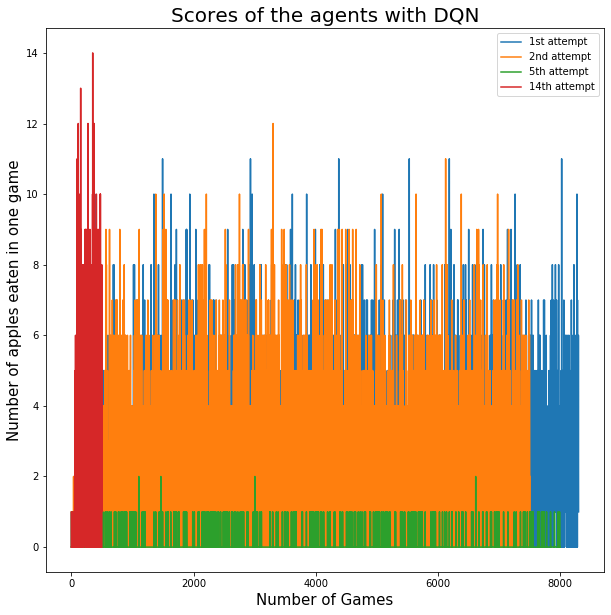

In [84]:
fig = plt.figure(figsize=(10,10))

plt.plot(DQN_2nd_attempt["Game Number"], DQN_2nd_attempt['Score'])
plt.plot(DQN_1st_attempt["Game Number"], DQN_1st_attempt['Score'])
plt.plot(DQN_5th_attempt["Game Number"][:8000], DQN_5th_attempt['Score'][:8000])
plt.plot(DQN_14th_attempt["Game Number"], DQN_14th_attempt['Score'])
plt.title("Scores of the agents with DQN", fontsize=20)
plt.xlabel("Number of Games", fontsize=15)
plt.ylabel("Number of apples eaten in one game", fontsize=15)
plt.legend(["1st attempt", "2nd attempt", "5th attempt", "14th attempt"])
plt.show()

### Comment on the plot:
It is clearly visible that the first two attempts of the agents with DQN failed. They never managed to eat apples on a regular basis, meaning at least 2 to 3 apples per game, since we see that the score 0 was very often realized. The 5th attempt is clearly a failure. 14th attempt was our best and it is clearly visible that the scores are rapidly fast on the highest level achieved from all our DQN agents.

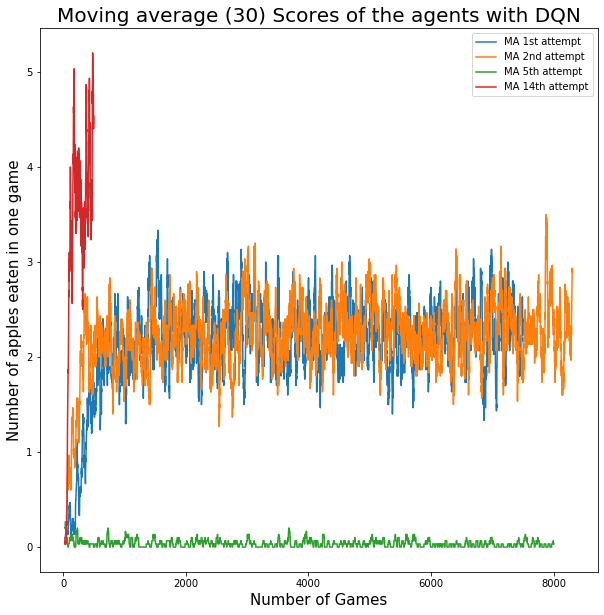

In [85]:
DQN_2nd_attempt['MA Score'] = DQN_2nd_attempt["Score"].rolling(window=30).mean()
DQN_1st_attempt['MA Score'] = DQN_1st_attempt["Score"].rolling(window=30).mean()
DQN_5th_attempt['MA Score'] = DQN_5th_attempt["Score"][:8000].rolling(window=30).mean()
DQN_14th_attempt['MA Score'] = DQN_14th_attempt["Score"].rolling(window=30).mean()


fig = plt.figure(figsize=(10,10))
plt.plot(DQN_1st_attempt["Game Number"], DQN_1st_attempt['MA Score'])
plt.plot(DQN_2nd_attempt["Game Number"], DQN_2nd_attempt['MA Score'])
plt.plot(DQN_5th_attempt["Game Number"][:8000], DQN_5th_attempt['MA Score'][:8000])
plt.plot(DQN_14th_attempt["Game Number"], DQN_14th_attempt['MA Score'])

plt.title("Moving average (30) Scores of the agents with DQN", fontsize=20)
plt.xlabel("Number of Games", fontsize=15)
plt.ylabel("Number of apples eaten in one game", fontsize=15)
plt.legend(["MA 1st attempt", "MA 2nd attempt", "MA 5th attempt", "MA 14th attempt"])
plt.show()

### Comment on the plot:
For the first two attempts we see:
a steeper learning curve for the second attempt, but at the same time, the learning flattens out much earlier (before a thousand games). It took the first agent 2000 games to reach the point where the learning flattens out.
But the 14th and last attempt had the steepest learning curve. We stopped the training then, since we ran out of time.

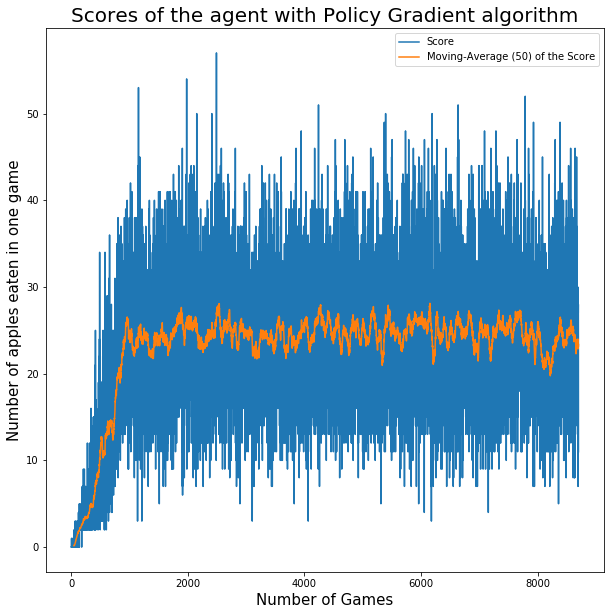

In [58]:
Policy_Gradient['MA Score'] = Policy_Gradient["Score"].rolling(window=50).mean()
fig = plt.figure(figsize=(10,10))
plt.plot(Policy_Gradient["Game Number"], Policy_Gradient["Score"])
plt.plot(Policy_Gradient["Game Number"], Policy_Gradient['MA Score'])
plt.title("Scores of the agent with Policy Gradient algorithm", fontsize=20)
plt.xlabel("Number of Games", fontsize=15)
plt.ylabel("Number of apples eaten in one game", fontsize=15)
plt.legend(["Score", "Moving-Average (50) of the Score"])
plt.show()

### Comment on the plot:
The learning curve was straight from the beginning very steep and after only two or three small perturbations the agent's performance settled at an average of around 25 apples per game.



### Plot on DQNCNN

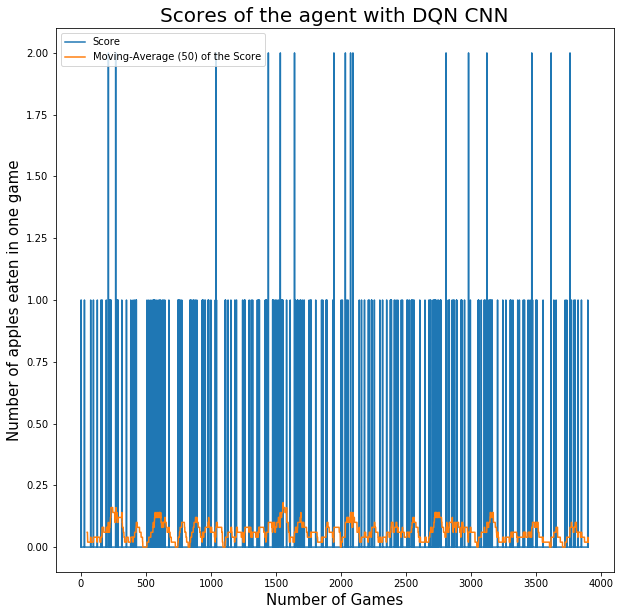

In [93]:
DQNCNN['MA Score'] = DQNCNN["Score"].rolling(window=50).mean()
fig = plt.figure(figsize=(10,10))
plt.plot(DQNCNN["Game Number"], DQNCNN["Score"])
plt.plot(DQNCNN["Game Number"], DQNCNN['MA Score'])
plt.title("Scores of the agent with DQN CNN", fontsize=20)
plt.xlabel("Number of Games", fontsize=15)
plt.ylabel("Number of apples eaten in one game", fontsize=15)
plt.legend(["Score", "Moving-Average (50) of the Score"])
plt.show()

### Comment:
We can see that the agent with a CNN model is not able to learn at all. The maximal score it got was 2 and it reached that score nearly random.

## 5. Conclusion
### Analysis on DQN:

All the adjustment and the whole process we made are documented under 1.3.

The problem we finally had that limited the agent's score that it began circling around the apple. This behavior gets worse over time. If the agent's snake is long enough he crashes into himself by chasing his tail. We don't know the exact reason for this behavior but we suspect that it lies ambiguity of the statespace when the snake is directly diagonal to the apple. One could add the state the that the apple is directly diagonally in front of the snake for all possible four directions. This would be a future project. 
We suspect the problem gets worse over time since the agent's memory gets full with state action reward pairs he cycles.

We tried to avoid the cycling problem with a net punishment for each step. And a version where the punishment is only given when the snake is going away from the apple. But these approaches didn't resolve the problem. Either the agent got suicidal or the cycling behavior remained depending on the strength of the punishment.

However our best score of 14 in our 14th attempt must not be underestimated. According to the paper Zhepei Wei et al [3] the human baseline of this game is 15.

### Analysis of the Agent with DQN CNN
The results are disappointing. We carried out 10 attempts (see section 2.3) and tested out many different hyperparameters for our CNN.


### Analysis of the Agent with Policy Gradient 
In further work, we would like to try to improve the agent's behavior by using more sophisticated reward functions to help the agent, increase the moving average above 25 apples. Possible reward functions to be used are proposed in the work of Zhepei Wei et al. [3] 
Moreover, we saw in multiple videos that the limitations for the score of the agent was enclosing in his own body. Given our state space the agent cannot avoid this problem because he only sees one step ahead. Therefore, for future work a CNN would have to be used.




## 6. References



[1] https://ai.stackexchange.com/questions/25086/how-is-the-dqn-loss-derived-from-or-theoretically-motivated-by-the-bellman-equ

[2] Lecture 6 and 7 of David Silver https://www.youtube.com/watch?v=UoPei5o4fps and https://www.youtube.com/watch?v=KHZVXao4qXs

[3] https://ieeexplore.ieee.org/document/8460004